In [2]:
import galsim
import batsim
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pyplot as plt
import fpfs
from time import time

from tqdm import tqdm, trange

In [3]:
def cancel_shape_noise(gal_obj, nrot):
    '''Create nrot rotated versions of the input galaxy object
    such that shape noise cancels out when averaging the shapes'''
    rotated_gals = []
    for i in range(nrot):
        rot_ang = np.pi / nrot * i
        ang = rot_ang * galsim.radians
        gal_obj = gal_obj.rotate(ang)
        rotated_gals.append(gal_obj)
        
    return rotated_gals

### Start with simplest test case, a circular Sersic profile

0.0006810353158702314 0.0
measured shear: 0.000682


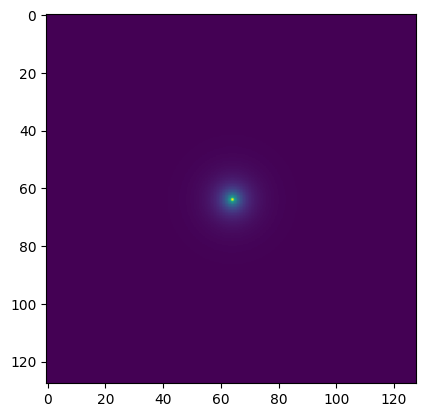

In [4]:
scale=0.2
nn=128
nrot = 4
hlr=1.5

sersic = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=40)
    
# Define IA transform
IAtransform = batsim.IaTransform(
    hlr=hlr,
    scale=scale,
    beta=0.,
    phi=np.radians(0),
    center=[0,0]
)

g1, g2 = IAtransform.get_g1g2(hlr,0)
print(g1, g2)

# Create the galaxy image
gal_array = batsim.simulate_galaxy(
        ngrid=nn,
        pix_scale=scale,
        gal_obj=sersic,
        transform_obj=IAtransform,
        psf_obj=None,
        draw_method="no_pixel",
    )

plt.imshow(gal_array)

# Attempt to measure shear with forced detection
# define PSF
psf_array = np.zeros((nn, nn))
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  = fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

In [5]:
# Drawing parameters
scale = 0.2
nn = 64

# load in COSMOS catalog
cosmos_cat = galsim.COSMOSCatalog()

# create a galaxy
rng = galsim.BaseDeviate(10)
randind = cosmos_cat.selectRandomIndex(rng=rng)
rec = cosmos_cat.getParametricRecord(index=randind)

gal = cosmos_cat.makeGalaxy(index=randind, gal_type='parametric')

print(gal.nyquist_scale)
print(gal.getGoodImageSize(gal.nyquist_scale))

if rec['use_bulgefit'] == 0:
    hlr = rec['hlr'][0]
else:
    hlr = rec['hlr'][2]

print(hlr)

0.03000779945283585
144
0.2873187919205763


In [8]:
print(rec['IDENT'])

100715


In [6]:
# Create rotated sample
nrot = 4
rotated_gals = cancel_shape_noise(gal, nrot)

# Total image size to contain all gals
scene_nn = int(nn * np.sqrt(1*nrot))

# PSF set-up
seeing = 0.67
psf_obj = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=4*seeing)

rcut = 16
psf_data = psf_obj.shift(0.5 * scale, 0.5 * scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale, method='auto')

# Define IA transform
IAtransform = batsim.IaTransform(
    hlr=hlr,
    scale=scale,
    beta=0.,
    phi=np.radians(0)
)

g1, g2 = IAtransform.get_g1g2(hlr,0)
print(g1, g2)

no_psf_image = galsim.ImageF(scene_nn, scene_nn, scale=scale)
psf_image = galsim.ImageF(scene_nn, scene_nn, scale=scale)
for i, obj in tqdm(enumerate(rotated_gals)):

    # set drawing location on image
    row = i // int(np.sqrt(1*nrot))
    col = i % int(np.sqrt(1*nrot))

    # Compute the bounds for this galaxy
    xmin = col * nn + 1  # +1 because GalSim coordinates start at 1
    xmax = (col + 1) * nn
    ymin = row * nn + 1
    ymax = (row + 1) * nn

    #Convolve with PSF
    psf_img = batsim.simulate_galaxy(
        ngrid=nn,
        pix_scale=scale,
        gal_obj=obj,
        transform_obj=IAtransform,
        psf_obj=psf_obj,
        draw_method="auto"
    )
    
    bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
    sub_image = galsim.Image(psf_img, scale=scale)
    psf_image.setSubImage(bounds, sub_image)

    # Generate image with no PSF
    no_psf_img = batsim.simulate_galaxy(
        ngrid=nn,
        pix_scale=scale,
        gal_obj=obj,
        transform_obj=IAtransform,
        psf_obj=None,
        draw_method="no_pixel"
    )

    sub_image = galsim.Image(no_psf_img, scale=scale)
    no_psf_image.setSubImage(bounds, sub_image)

0.0006810353158702314 0.0


1it [00:00,  5.93it/s]

4it [00:00,  9.61it/s]


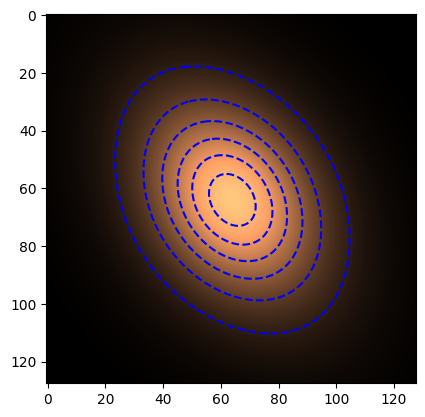

In [7]:
IAtransform_exg = batsim.IaTransform(
    hlr=hlr,
    scale=scale,
    beta=0.82,
    phi=np.radians(0)
)

batsim_im = batsim.simulate_galaxy(
    ngrid=128,
    pix_scale=0.02,
    gal_obj=gal,
    transform_obj=IAtransform_exg,
    psf_obj=psf_obj,
    draw_method="auto"
)

plt.imshow(batsim_im, cmap='copper')
plt.contour(batsim_im, colors='b', linestyles='--')

In [8]:
# FPFS measurement function
def test_kernel_size(sigma_arcsec, psf_arr, gal_arr, scale, rcut):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    scene_nx = gal_arr.shape[0]
    scene_ny = gal_arr.shape[1]

    ### Let FPFS handle detection ###
    p1 = scene_nx //2 - rcut
    p2 = scene_ny //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

    coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00)
    
    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp
    shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(1*nrot)

    return shear, shear_err

In [9]:
# Measure on PSF-less image
kernel = 0.4

psf_array = np.zeros((rcut*2, rcut*2))
psf_array[int(rcut), int(rcut)] = 1

# measure on batsim galaxies
shear, shear_err = test_kernel_size(sigma_arcsec=kernel, psf_arr=psf_array,
                                            gal_arr=no_psf_image.array, scale=scale, rcut=rcut)
print("no psf shear: ", shear)
print("no psf shear error: ", shear_err)

m_bias = abs(shear - g1)/g1
print("m_bias: ", m_bias)


no psf shear:  0.0007000028348382401
no psf shear error:  0.15397886965508445
m_bias:  0.027851006439764257


In [10]:
# smaller kernel
kernel = 0.4

# measure on batsim galaxies
shear1, shear_err = test_kernel_size(sigma_arcsec=kernel, psf_arr=psf_data.array, 
                                            gal_arr=psf_image.array, scale=scale, rcut=rcut)
print("psf shear: ", shear1)
print("psf shear error: ", shear_err)

m_bias = abs(shear1 - g1)/g1
print("m_bias: ", m_bias)

psf shear:  0.0006810519945925578
psf shear error:  0.15003586015325437
m_bias:  2.4490245862083267e-05


In [11]:
# smaller kernel
kernel = 0.8

# measure on batsim galaxies
shear2, shear_err = test_kernel_size(sigma_arcsec=kernel, psf_arr=psf_data.array, 
                                            gal_arr=psf_image.array, scale=scale, rcut=rcut)
print("psf shear: ", shear2)
print("psf shear error: ", shear_err)

m_bias = abs(shear2 - g1)/g1
print("m_bias: ", m_bias)

psf shear:  0.0006810243438418167
psf shear error:  0.14023756818029692
m_bias:  1.611080682462146e-05


In [12]:
a = shear1 / shear2
print(a)

1.0000406017068129


### Run larger scale test

In [13]:
# create a galaxy
rng = galsim.BaseDeviate(10)
randind = cosmos_cat.selectRandomIndex(rng=rng, n_random=100)
recs = cosmos_cat.getParametricRecord(index=randind)

hlrs=[]
for i in range(len(recs['hlr'])):
    if recs['use_bulgefit'][i] == 0:
        hlr = recs['hlr'][i][0]
    else:
        hlr = recs['hlr'][i][2]
    hlrs.append(hlr)
    
gals = cosmos_cat.makeGalaxy(index=randind, gal_type='parametric')

nn = 256
scale = 0.2
nrot = 4

inner_kernel = 0.4
outer_kernel = 0.8

# PSF set-up
seeing = 0.67
psf_obj = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=4*seeing)

rcut = 16
psf_data = psf_obj.shift(0.5 * scale, 0.5 * scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale, method='auto')

In [14]:
psf_diffs = []
no_psf_diffs = []
for i, gal in tqdm(enumerate(gals)):

    # Create rotated sample
    nrot = 4
    rotated_gals = cancel_shape_noise(gal, nrot)

    # Total image size to contain all gals
    scene_nn = int(nn * np.sqrt(1*nrot))

    # PSF set-up
    seeing = 0.67
    psf_obj = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=4*seeing)

    rcut = 16
    psf_data = psf_obj.shift(0.5 * scale, 0.5 * scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale, method='auto')

    # Define IA transform
    IAtransform = batsim.IaTransform(
        hlr=hlr,
        scale=scale,
        beta=0.82,
        phi=np.radians(0)
    )

    no_psf_image = galsim.ImageF(scene_nn, scene_nn, scale=scale)
    psf_image = galsim.ImageF(scene_nn, scene_nn, scale=scale)
    for i, obj in enumerate(rotated_gals):

        # set drawing location on image
        row = i // int(np.sqrt(1*nrot))
        col = i % int(np.sqrt(1*nrot))

        # Compute the bounds for this galaxy
        xmin = col * nn + 1  # +1 because GalSim coordinates start at 1
        xmax = (col + 1) * nn
        ymin = row * nn + 1
        ymax = (row + 1) * nn

        #Convolve with PSF
        psf_img = batsim.simulate_galaxy(
            ngrid=nn,
            pix_scale=scale,
            gal_obj=obj,
            transform_obj=IAtransform,
            psf_obj=psf_obj,
            draw_method="auto"
        )
        
        bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
        sub_image = galsim.Image(psf_img, scale=scale)
        psf_image.setSubImage(bounds, sub_image)

        # Generate image with no PSF
        no_psf_img = batsim.simulate_galaxy(
            ngrid=nn,
            pix_scale=scale,
            gal_obj=obj,
            transform_obj=IAtransform,
            psf_obj=None,
            draw_method="no_pixel"
        )

        sub_image = galsim.Image(no_psf_img, scale=scale)
        no_psf_image.setSubImage(bounds, sub_image)

    dummy_psf_array = np.zeros((rcut*2, rcut*2))
    dummy_psf_array[int(rcut), int(rcut)] = 1

    no_psf_shear_inner, _ = test_kernel_size(sigma_arcsec=inner_kernel, psf_arr=dummy_psf_array,
                                            gal_arr=no_psf_image.array, scale=scale, rcut=rcut)
    
    no_psf_shear_outer, _ = test_kernel_size(sigma_arcsec=outer_kernel, psf_arr=dummy_psf_array,
                                            gal_arr=no_psf_image.array, scale=scale, rcut=rcut)
    
    psf_shear_inner, _ = test_kernel_size(sigma_arcsec=inner_kernel, psf_arr=psf_data.array,
                                            gal_arr=psf_image.array, scale=scale, rcut=rcut)
    
    psf_shear_outer, _ = test_kernel_size(sigma_arcsec=outer_kernel, psf_arr=psf_data.array,
                                            gal_arr=psf_image.array, scale=scale, rcut=rcut)
    
    psf_diffs.append(psf_shear_inner - psf_shear_outer)
    no_psf_diffs.append(no_psf_shear_inner - no_psf_shear_outer)

0it [00:00, ?it/s]

2it [00:06,  3.23s/it]


KeyboardInterrupt: 

In [ ]:
print(psf_diffs)

[0.00031007686314896447, 0.0004404387948635754, 0.0006228547700627923, 0.0005524020433100426, 0.0005957860465320192, 0.0005295481176667275, 0.0003370018562980862, 0.0004610173733859827, 7.455241504368592e-05, 0.0002558372043892697, 0.00042160381332313936, 0.00018014086857597077, 0.0005441638322174439, 0.0004884208572941396, 0.0004541923254203356, 0.0004520664962631517, 0.0005417963502028645, 0.00043230453540586114, 0.0005145088552759809, -3.337150944462486e-05, 0.0005639066962483646, 0.00015904799312099955, -1.4232211145016925e-05, 9.72704933221468e-05, 0.00026871768595982857, 0.00042178060937878736, -6.820246329389658e-06, -4.3338197338816265e-05, 0.00012334184441631976, 0.00031459927949507903, 0.0006302872263634903, 0.0005584559035866178, 0.00022931431231600183, 0.00032985925549553906, 0.0005651685466546711, 0.0004649075055008268, 4.6754836011520624e-05, 0.00015494691703225828, 0.00032617191425932893, 0.0006133194004041365, 0.0005281942588092286, 0.0005530026217740127, 0.000545394078

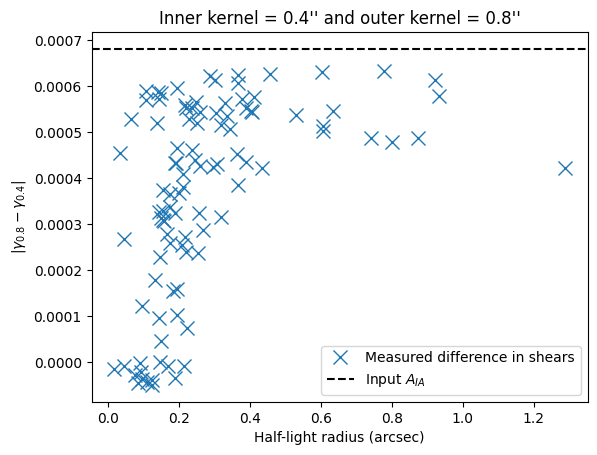

In [ ]:
plt.plot(hlrs, psf_diffs, label="Measured difference in shears", lw=0, marker='x', ms=10)
plt.axhline(g1,c ='black', label=r'Input $A_{IA}$', ls='--')
plt.xlabel("Half-light radius (arcsec)")
plt.ylabel(r'$|\gamma_{0.8} - \gamma_{0.4}|$')
plt.title("Inner kernel = 0.4'' and outer kernel = 0.8''")
plt.legend()

<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

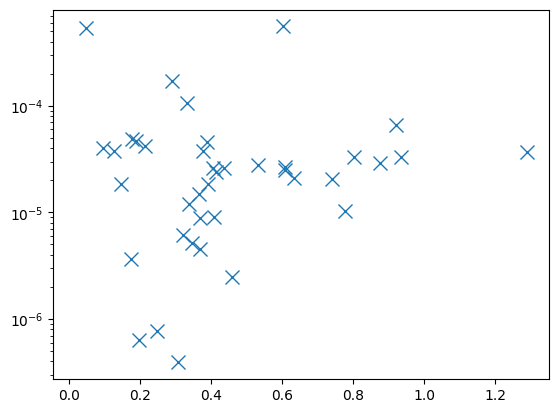

In [ ]:
diffs_diffs = np.array(psf_diffs) - np.array(no_psf_diffs)

plt.plot(hlrs, diffs_diffs, lw=0, marker='x', ms=10)
plt.yscale('log')
plt.title

In [15]:
ngals = 16 # Currently must result in an integer sqrt
nrot = 4
nn = 128
scale = 0.2
scene_nn = int(nn * np.sqrt(ngals * nrot))

# PSF setup
seeing = 0.67
psf_obj = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=4 * seeing)

# Large image to contain all galaxies
psf_image = galsim.ImageF(scene_nn, scene_nn, scale=scale)

# Initialize random number generator
rng = galsim.BaseDeviate(14)
randind = cosmos_cat.selectRandomIndex(rng=rng, n_random=ngals)
recs = cosmos_cat.getParametricRecord(index=randind)
gal_sample = cosmos_cat.makeGalaxy(index=randind, gal_type='parametric')

# Create rotated and processed sample
rotated_gals = []
for gal in tqdm(gal_sample):
    rotated_gals.extend(cancel_shape_noise(gal, nrot))

# Iterate over each galaxy in the processed sample
for i, gal in enumerate(tqdm(rotated_gals)):
    if i % 4 == 0:
        if recs['use_bulgefit'][i // 4] == 0:
            hlr = recs['hlr'][i // 4][0]
        else:
            hlr = recs['hlr'][i // 4][2]

        # Define IA transform
        IAtransform = batsim.IaTransform(
            hlr=hlr,
            scale=scale,
            beta=0.82,
            phi=np.radians(0)
        )

    # Set drawing location on image
    row = i // int(np.sqrt(ngals * nrot))
    col = i % int(np.sqrt(ngals * nrot))

    xmin = col * nn + 1
    xmax = (col + 1) * nn
    ymin = row * nn + 1
    ymax = (row + 1) * nn

    # Convolve with PSF
    psf_img = batsim.simulate_galaxy(
        ngrid=nn,
        pix_scale=scale,
        gal_obj=gal,
        transform_obj=IAtransform,
        psf_obj=psf_obj,
        draw_method="auto"
    )

    bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
    sub_image = galsim.ImageF(psf_img, scale=scale)
    psf_image.setSubImage(bounds, sub_image)

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [01:16<00:00,  1.19s/it]


Text(0.5, 1.0, 'COSMOS galaxies with IA shear and Moffat PSF')

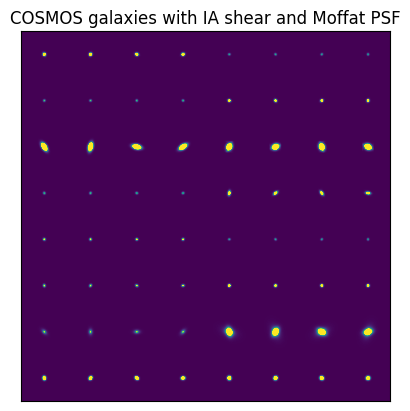

In [ ]:
plt.imshow(psf_image.array, norm=plt.Normalize(0, 0.1))
plt.xticks([])
plt.yticks([])
plt.title("COSMOS galaxies with IA shear and Moffat PSF")

In [ ]:
shear1, shear_err = test_kernel_size(sigma_arcsec=0.3, psf_arr=psf_data.array,
                                    gal_arr=psf_image.array, scale=scale, rcut=rcut)

print("Measured shear: %.6f" % shear1)

Measured shear: 0.000740


In [ ]:
shear2, shear_err = test_kernel_size(sigma_arcsec=1.0, psf_arr=psf_data.array,
                                    gal_arr=psf_image.array, scale=scale, rcut=rcut)

print("Measured shear: %.6f" % shear2)

Measured shear: 0.001151


In [ ]:
print(shear1/shear2)

0.6431407822017294
